In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import unittest
from image_process import *
import glob
import cv2
from os.path import join, split, splitext

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dummy_img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = get_cv2_img_size(dummy_img)
IMG_FOLDER = './camera_cal/calibration*.jpg'
NX = 9
NY = 6
camcal = CameraCalibrator(img_size, IMG_FOLDER, NX, NY)

In [3]:
test_image_file="./problematic_images/frame_1.0.jpg"
#test_image_file="./test_images/test1.jpg"

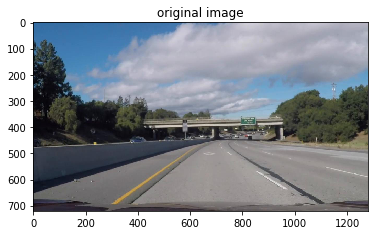

In [4]:
test_image = cv2.imread(test_image_file)
n_image = camcal.transform(test_image)
plt.imshow(np.flip(test_image, axis=2))
plt.title("original image")

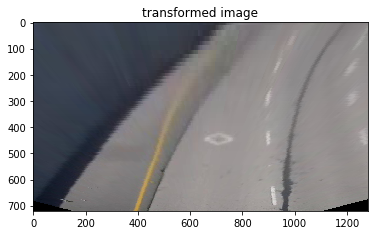

In [5]:
perspect_image = PerspectiveTransformer().transform(n_image)
plt.imshow(np.flip(perspect_image, axis=2))
plt.title("transformed image")

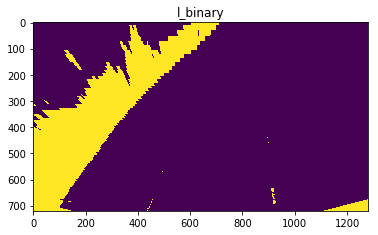

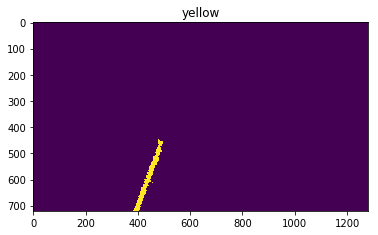

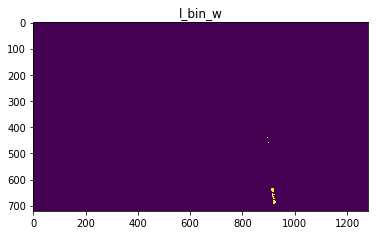

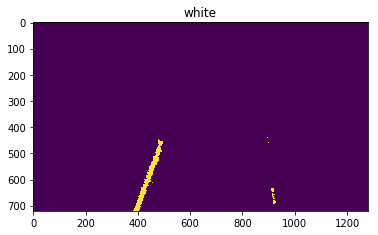

In [6]:
combined, img_comp = yellow_white_luv(perspect_image)

for img in img_comp.keys():
    plt.figure()
    plt.imshow(img_comp[img])
    plt.title(img)
    #plt.savefig("./output_images/demo_bin_%s.jpg" % img)

plt.imshow(combined)
#plt.savefig("./output_images/demo_bin_all.jpg")

## Test the results of ```EdgeExtractor```

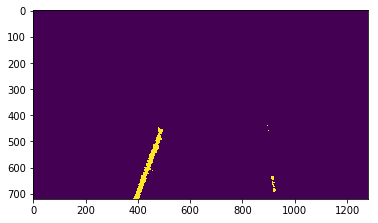

In [7]:
pip = Pipeline([('cam', camcal) ,('pers', PerspectiveTransformer()),('undistort', EdgeExtractor())
                ])

n_image = pip.fit_transform(test_image)
plt.figure()
plt.imshow(n_image)

In [8]:
lf=LaneFinder()
pip = Pipeline([('cam', camcal) ,('pers', PerspectiveTransformer()),('undistort', EdgeExtractor()),('lf',lf)
                ])

n2_image = pip.fit_transform(test_image)
lf.visualize(n_image)
#plt.figure()
#plt.imshow(n_image)

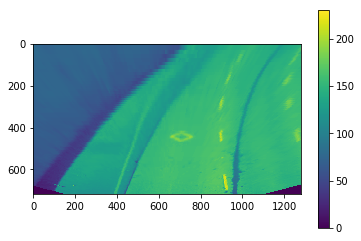

In [9]:
luv_img = cv2.cvtColor(perspect_image, cv2.COLOR_RGB2LUV)
plt.imshow(luv_img[:,:,0])
plt.colorbar()

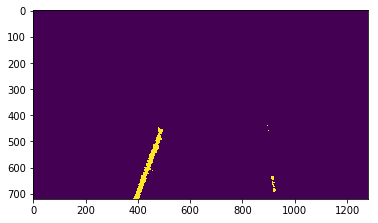

In [10]:
plt.imshow(lf.raw_image)

In [11]:
luv_img.shape

(720, 1280, 3)

In [12]:
def draw_gaussian(img, leftx, rightx):
    new_image=np.empty_like(img).astype(np.float32)
    
    sigma=80
    #coef=1/np.sqrt(2*np.pi*sigma**2)
    coef=1
    
    for x in range(new_image.shape[1]):
        new_image[:,x]=coef*np.exp(-(x-leftx)**2/(2*sigma**2))+coef*np.exp(-(x-rightx)**2/(2*sigma**2))
    
    return new_image

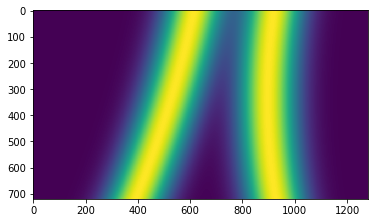

In [13]:
gaussian_img=draw_gaussian(luv_img[:,:,0],lf.fitted_param['left_fitx'],lf.fitted_param['right_fitx'])
plt.imshow(gaussian_img)

In [14]:
gaussian_img=lf.gaussian_filter(left_on=True,right_on=False)

In [15]:
np.max(gaussian_img)

1.0

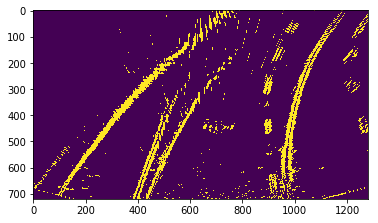

In [16]:
sobel_img=abs_sobel_thresh(luv_img[:,:,0], orient='x',sobel_kernel=5, thresh=(10, 80), to_gray=False)
plt.imshow(sobel_img)

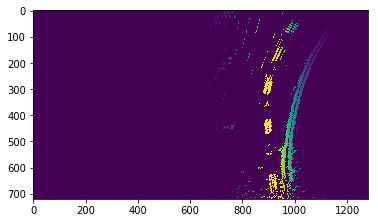

In [17]:
gaussian_img_right=lf.gaussian_filter(left_on=False,right_on=True)
plt.imshow(gaussian_img_right*sobel_img)

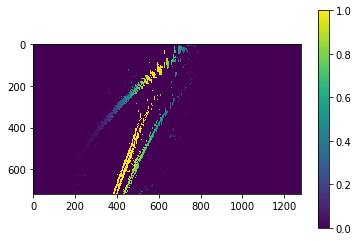

In [18]:
mul_img=gaussian_img*sobel_img
plt.imshow(mul_img)
plt.colorbar()

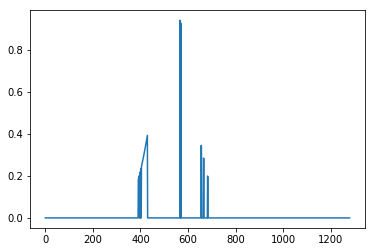

In [19]:
plt.plot(mul_img[300,:])

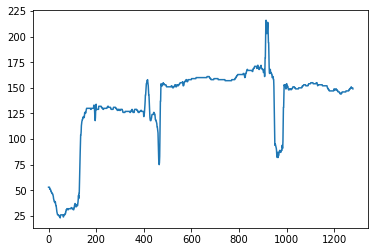

In [20]:
plt.plot(luv_img[650,:,0])

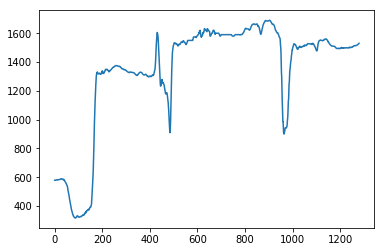

In [21]:
plt.plot(np.sum(luv_img[600:610,:,0],axis=0))

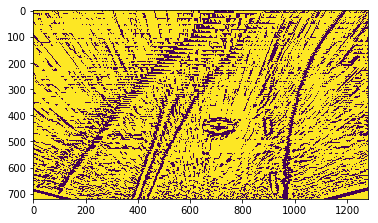

In [22]:
th3 = cv2.adaptiveThreshold(luv_img[:,:,0],1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,31,1)
plt.imshow(th3)

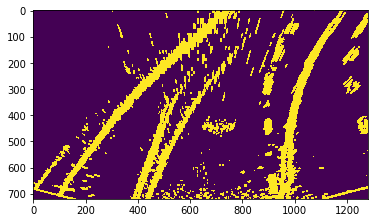

In [23]:
img = cv2.imread('j.png',0)
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(sobel_img,kernel,iterations = 1)
plt.imshow(dilation)

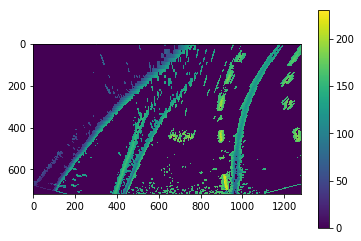

In [36]:
filtered_img=luv_img[:,:,0]*dilation
plt.imshow(filtered_img)
plt.colorbar()

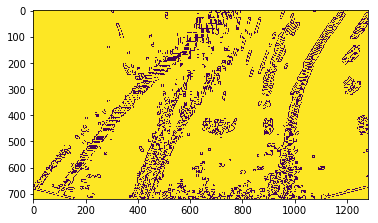

In [37]:
th3 = cv2.adaptiveThreshold(filtered_img,1,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,5,1)
plt.imshow(th3)


In [38]:
img_comp.keys()

dict_keys(['l_binary', 'yellow', 'l_bin_w', 'white'])

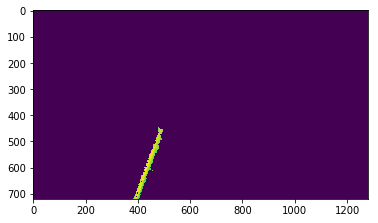

In [39]:
n_img=img_comp['yellow']*filtered_img
plt.imshow(n_img)

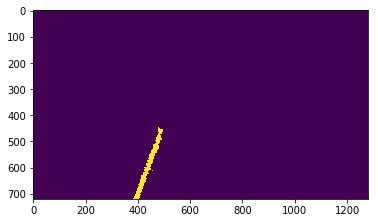

In [40]:
plt.imshow(img_comp['yellow'])

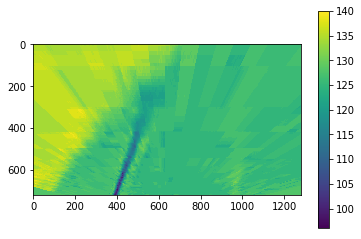

In [41]:
lab_img = cv2.cvtColor(perspect_image, cv2.COLOR_RGB2LAB)
plt.imshow(lab_img[:,:,2])
plt.colorbar()

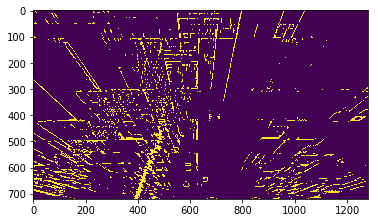

In [42]:
th3 = cv2.adaptiveThreshold(lab_img[:,:,2],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,31,1)
plt.imshow(th3)

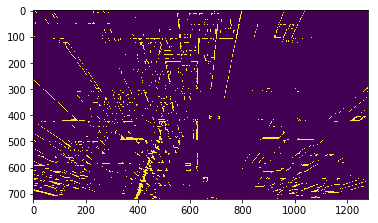

In [43]:
kernel = np.ones((2,2),np.uint8)
erosion = cv2.erode(th3,kernel,iterations = 1)
plt.imshow(erosion)

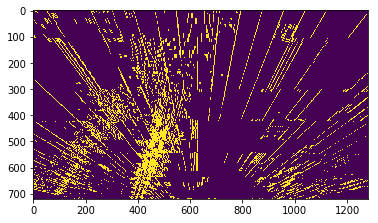

In [46]:
n_img=abs_sobel_thresh(lab_img[:,:,2], orient='x', 
                 sobel_kernel=5, thresh=(10, 100), to_gray=False)
plt.imshow(n_img)

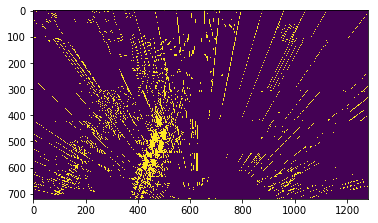

In [47]:
kernel = np.ones((2,2),np.uint8)
erosion = cv2.erode(n_img,kernel,iterations = 1)
plt.imshow(erosion)

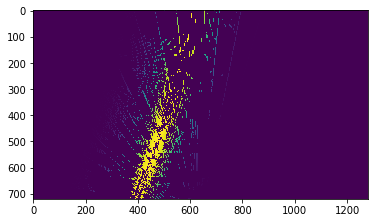

In [48]:
n_img=gaussian_img*erosion
plt.imshow(n_img)

In [51]:
lf=MultiPassLaneFinder()
pip = Pipeline([('cam', camcal) ,('pers', PerspectiveTransformer()),('lf',lf)
                ])

n2_image = pip.fit_transform(test_image)
lf.visualize(n_image)

AttributeError: 'tuple' object has no attribute 'shape'